In [ ]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
import sklearn as sk
import skimage
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as spio
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
import random
from google.colab import drive
np.random.seed(816)
random.seed(979)

In [ ]:
EXPERIMENT_NAME = "EXP_12"


N_LAYERS = 2 
POOLING_PROPORTION = 2 
POOLING_SHAPE = (POOLING_PROPORTION, POOLING_PROPORTION) 
ACTIVATION_FUNCTION = keras.layers.LeakyReLU() 
OPTMIZER = opt = keras.optimizers.adam_v2.Adam() 
DROPOUT_RATE = 0.25
LOSS_FUNCTION = keras.losses.mean_squared_logarithmic_error 


METRICS_LIST = ['MAE'] 
BATCH_SIZE = 4 
EPOCHS_NUM = 15 


FOREIGN_ALPHABET_PATH = '3.txt'
OUPUT_TTF_FILE_NAME = 'FZJiaGW.ttf' 
INTPUT_TTF_FILE_NAME = 'HYChenTiJiaGuWen.ttf' 

INPUT_IMG_SIDE = 160 
OUTPUT_IMG_SIDE = INPUT_IMG_SIDE//POOLING_PROPORTION 
INPUT_SHAPE = (INPUT_IMG_SIDE, INPUT_IMG_SIDE) 
OUTPUT_SHAPE = (OUTPUT_IMG_SIDE, OUTPUT_IMG_SIDE) 

FREE_EDGE = 2 
CENTRALIZED_IMAGES = True 

INPUT_FONT_SIZE = 157 
OUTPUT_FONT_SIZE = 74 

IMAGE_TYPE = '1' 
BACKGROUND_VALUE = 1 

#Outros
RESULTS_PATH = '/content/drive/MyDrive/Colab Notebooks/Font-style-transfer-master/jiaguwen/'

TRAIN_VALIDATE_SET_SIZE = None 

NUM_FOREIGN_TEST = None 

Abre drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


数据路径

In [ ]:
root_path_output_ttf = '/content/drive/MyDrive/Colab Notebooks/Font-style-transfer-master/jiaguwen/' + OUPUT_TTF_FILE_NAME #输入源
root_path_input_ttf = '/content/drive/MyDrive/Colab Notebooks/Font-style-transfer-master/jiaguwen/' + INTPUT_TTF_FILE_NAME #输出源
root_path_foreign_alphabet ='/content/drive/MyDrive/Colab Notebooks/Font-style-transfer-master/jiaguwen/' + FOREIGN_ALPHABET_PATH #使用的字母表中的字符列表

在报告和图像中保存文本的函数(名称以实验名称开头),记录数据保存在EXP12.txt文件中。 

In [ ]:
def saveText(text):        #保存text到输出txt文件中
  f = open(RESULTS_PATH + EXPERIMENT_NAME + '.txt', "a")
  f.write(text + '\n')
  f.close()     

保存图片，并在txt文件中记录

In [ ]:
def saveImage(img, name, description):
  #保存图片到文件夹
  io.imsave(RESULTS_PATH + EXPERIMENT_NAME + '_' + name + '.png', img)  #ndarray of shape (M,N) or (M,N,3) or (M,N,4)，Image data.
  #在报告中保存图像的描述和名称 
  f = open(RESULTS_PATH + EXPERIMENT_NAME + '.txt', "a")
  f.write(description + ': ' + name + '.png \n')
  f.close()

保存折线图

In [ ]:
def saveGraph(name, description):
  plt.savefig(RESULTS_PATH + EXPERIMENT_NAME + '_' + name + '.png')
  f = open(RESULTS_PATH + EXPERIMENT_NAME + '.txt', "a")
  f.write(description + ': ' + name + '.png \n')
  f.close()

"从选定的源创建图像列表"

In [ ]:
#Define alfabetos usados
      
#罗马字符和数字的列表
#romanCharsLower = 'a b c d e f g h i j k l m n o p q r s t u v w x y z'.split()
#romanCharsUpper = 'A B C D E F G H I J K L M N O P Q R S T U V W X Y Z'.split()
#numerals = '0 1 2 3 4 5 6 7 8 9'.split()

#字母和数字数
#nonForeignLen = len(romanCharsLower) + len(romanCharsUpper) + len(numerals)

#汉语字符列表
if len(root_path_foreign_alphabet) != 0:
  foreignChars = open(root_path_foreign_alphabet).read().split() #对txt文件split换行符也是默认切割的
else:
  foreignChars = []

In [ ]:
len(foreignChars)

412

In [ ]:
#返回字符图像，做个背景，把字放上去
def drawChar(char, shape, font):
  img = Image.new(IMAGE_TYPE, shape, BACKGROUND_VALUE)
  draw = ImageDraw.Draw(img)
  draw.text((FREE_EDGE + 1, FREE_EDGE + 1),char, 0 ,font=font)
  draw = ImageDraw.Draw(img)
  return np.array(img)

In [ ]:
img = Image.new("L",(150,150),0)#ImageFont.truetype必须有
draw = ImageDraw.Draw(img)
font = ImageFont.truetype(root_path_input_ttf,24)

draw.text((20 + 1, 20 + 1),'char', 10 ,font)
draw = ImageDraw.Draw(img)
a=np.array(img)


In [ ]:
a.shape[0]-1

149

In [ ]:
#检查字符n是否被切割(检查图像边缘是否为白色)，检测了四个区域 
def fullCharacterExposed(img):
  for index in range(0, FREE_EDGE):
    if False in (img[index, :] == BACKGROUND_VALUE): #图片到FREE_EDGE这一行
      return False
    if False in (img[img.shape[0] - 1 - index, :] == BACKGROUND_VALUE): #图片到FREE_EDGE这一行另一侧
      return False
    if False in (img[:, index] == BACKGROUND_VALUE): #图片到FREE_EDGE这一列
      return False
    if False in (img[:, img.shape[1] - 1 - index] == BACKGROUND_VALUE): #图片到FREE_EDGE这一行另一侧
      return False
    
  return True

In [ ]:
#使字符在图像中居中

import numpy as np
import math

def centralizeImage(img):
  original_shape = img.shape
  if(len(original_shape) >  2):
    img = img.reshape(original_shape[0], original_shape[1])
  
  left_limit = 0        #上下左右四个方向开始检测，直到和背景色不一致停止           
  while(left_limit < img.shape[1] and (False not in (img[:,left_limit] == BACKGROUND_VALUE))):
    left_limit += 1

  right_limit = img.shape[1] - 1
  while(right_limit >= 0 and (False not in (img[:,right_limit] == BACKGROUND_VALUE))):
    right_limit -= 1
  
  upper_limit = 0
  while(upper_limit < img.shape[0] and (False not in (img[upper_limit,:] == BACKGROUND_VALUE))):
    upper_limit += 1
  
  lower_limit = img.shape[0] - 1
  while(lower_limit >= 0 and (False not in (img[lower_limit,:] == BACKGROUND_VALUE))):
    lower_limit -= 1
  
  hshift = math.ceil((img.shape[1] - right_limit - left_limit - 1)/2) #math.ceil(x) 方法将 x 向上舍入到最接近的整数。
  vshift = math.ceil((img.shape[0] - lower_limit - upper_limit - 1)/2)
  
  hpadding = np.zeros((img.shape[0], abs(hshift)), np.uint8)
  hpadding[:, :] = BACKGROUND_VALUE

  if hshift > 1:
    img = np.hstack((hpadding, img[:, :-hshift]))
                    
  elif hshift < -1:
    img = np.hstack((img[:, -hshift:], hpadding))

  vpadding = np.zeros((abs(vshift), img.shape[0]), np.uint8)
  vpadding[:, :] = BACKGROUND_VALUE

  if vshift > 1:                         #大于1就往前面加，小于1就往后面加画个图就更明显了
    img = np.vstack((vpadding, img[:-vshift, :]))

  elif vshift < -1:
    img = np.vstack((img[-vshift:, :], vpadding))

  return img.reshape(original_shape)    

In [ ]:
#生成带有选定源中生成的字符的图像列表，将所有字符放入image_list

def generateImageList(font, shape):
  image_list = []
  
  #for char in romanCharsUpper:
  #  img = drawChar(char, shape, font)
  #  image_list.append(img)
  
  #for char in romanCharsLower:
  #  img = drawChar(char, shape, font)
  #  image_list.append(img)
    
 # for char in numerals:
  #  img = drawChar(char, shape, font)
  #  image_list.append(img)
  
  for char in foreignChars:
    img = drawChar(char, shape, font)
    image_list.append(img)
  
  if CENTRALIZED_IMAGES:
    for index in range(0, len(image_list)):
      image_list[index] = centralizeImage(image_list[index])
  
  return image_list

In [ ]:
#更大的字体大小，不超过定义的格式限制 

import skimage as ski
def bestFontSize(font_path, shape):
  #对字体大小进行二进制搜索
  min_size = 1
  max_size = max(shape[0], shape[1]) 
  while min_size < max_size:
    mid = (min_size + max_size + 1)//2
    font = ImageFont.truetype(font_path, size = mid)
    image_list = generateImageList(font, shape)
    list_ok = True
    for element in image_list:
      if fullCharacterExposed(element) == False:  #只要有越出去的循环就停止
        list_ok = False
        break
    
    if list_ok:
      min_size = mid
    
    else:
      max_size = mid - 1
  
  
  return min_size
        

In [ ]:
#Se os tamanhos das fontes nao forem definidos na entrada, encontra valores para esses
if INPUT_FONT_SIZE == None:
  INPUT_FONT_SIZE = bestFontSize(root_path_input_ttf, INPUT_SHAPE)
  
if OUTPUT_FONT_SIZE == None:
  OUTPUT_FONT_SIZE = bestFontSize(root_path_output_ttf, OUTPUT_SHAPE)

print(INPUT_FONT_SIZE)
print(OUTPUT_FONT_SIZE)

157
74


In [ ]:
#Gera fontes
inputFont = ImageFont.truetype(root_path_input_ttf, size = 157) #Importa fonte usada
outputFont = ImageFont.truetype(root_path_output_ttf, size = 74) #Importa fonte usada

In [ ]:
[1,2]+[3,4]

[1, 2, 3, 4]

In [ ]:
#Gera listas de imagens
input_images = generateImageList(inputFont, INPUT_SHAPE)
output_images = generateImageList(outputFont, OUTPUT_SHAPE)

将图像列表转换为numpy向量

In [ ]:
#传递唯一张量的图像列表,编程了三维张量

import numpy as np

def imageList2NumpyList(image_list):
  numpy_list = []
  for index in range(0, len(image_list)):
    tensor = np.zeros(image_list[index].shape, np.uint8) #Cria vetor
    tensor = image_list[index] #atribui valores da image
    tensor = tensor.reshape(tensor.shape[0], tensor.shape[1], 1) #Adiciona dimensão para numero de canais
    numpy_list.append(tensor)
  return numpy_list
    

In [ ]:
#Passa lista de imagens para tensor unico

input_tensors = np.array(imageList2NumpyList(input_images))
output_tensors = np.array(imageList2NumpyList(output_images))

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


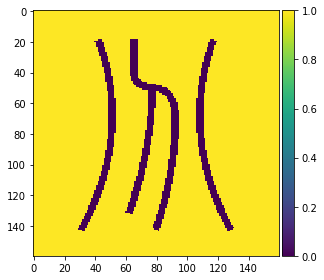

In [ ]:
a=input_tensors[79].reshape(INPUT_SHAPE) 

ski.io.imshow(a)


单独的培训、验证和测试集 

In [ ]:
#初始指数集
nonForeignLen=30
valid_indexes = [x for x in range(nonForeignLen, len(input_tensors))]

remaining_indexes = []

#删除未正确加载的图像 
for index in valid_indexes:
  if (input_tensors[index] != BACKGROUND_VALUE).any() and (output_tensors[index] != BACKGROUND_VALUE).any():#BACKGROUND_VALUE = 1,如果都是1就都是false结果就是false 
    remaining_indexes.append(index)

#保存未正确打开的字符数 
saveText("未读字符:" + str(len(valid_indexes) - len(remaining_indexes)) + '/' + str(len(valid_indexes)))  

#如果指定，选择用于培训/验证的索引子集
if TRAIN_VALIDATE_SET_SIZE:     #程序中TRAIN_VALIDATE_SET_SIZE==None也就是并没有设定验证集
   remaining_indexes = random.sample(remaining_indexes, TRAIN_VALIDATE_SET_SIZE)
    
#生成一组测试指标
test_indexes = [x for x in range(0, nonForeignLen)] #生成测试索引集添加罗马字符和数字 
if NUM_FOREIGN_TEST == None:
  NUM_FOREIGN_TEST = nonForeignLen
foreign_test_indexes = random.sample(remaining_indexes, NUM_FOREIGN_TEST) #从外国字符中提取示例
for element in foreign_test_indexes: #从可用索引列表中删除
  remaining_indexes.remove(element)
test_indexes += foreign_test_indexes  #抽取相同数量的中文和字母合成测试集
if len(remaining_indexes)%2 == 1: #确保剩余集是偶数
  test_indexes.append(remaining_indexes[0])
  remaining_indexes.remove(remaining_indexes[0])
  
#生成测试集
test_input = []
test_output = []  
for index in test_indexes:
  test_input.append(input_tensors[index])
  test_output.append(output_tensors[index])
test_input = np.array(test_input)
test_output = np.array(test_output)  


#生成测试集训练指标集 
train_size = len(remaining_indexes)//2
train_indexes = random.sample(remaining_indexes, train_size) #extraindo metade dos exemplos para treino
for element in train_indexes: #Remove da lista de indices disponiveis
  remaining_indexes.remove(element)

#Gera conjunto de treinamento 
train_input = []
train_output = []  
for index in train_indexes:
  train_input.append(input_tensors[index])
  train_output.append(output_tensors[index])  
train_input = np.array(train_input)
train_output = np.array(train_output)  


#Gera conjunto de validação 
validate_input = []
validate_output = []  
for index in remaining_indexes:
  validate_input.append(input_tensors[index])
  validate_output.append(output_tensors[index])  
validate_input = np.array(validate_input)
validate_output = np.array(validate_output)  


In [ ]:
#Gera conjuntos de validação e treinamento (usar aqui para data augmentation)
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator()

datagen.fit(train_input)

valgen = ImageDataGenerator()

valgen.fit(validate_input)

Arquitetura da rede

In [ ]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LeakyReLU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv1D
import os

model = Sequential()

#将字符集中在输入卷积图像中 
model.add(Conv2D(8, (64, 64), input_shape=INPUT_SHAPE + (1,), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
model.add(Conv2D(8, (64, 64), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
          
#Camadas convolucionais repetidas          
for i in range (0, N_LAYERS):
  model.add(Conv2D(32, (32, 32), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

for i in range(0, N_LAYERS):
  model.add(Conv2D(64, (16, 16), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

for i in range(0, N_LAYERS):
  model.add(Conv2D(128, (7, 7), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

#Camadas convolucionais de saida
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))
model.add(Conv2D(1, (3, 3), padding='same'))
model.add(BatchNormalization(axis=-1, momentum=0.9, epsilon=0.01))

#Reduz dimensões da saida
model.add(MaxPooling2D(pool_size=POOLING_SHAPE))  

#Define dropout e ativação
model.add(Dropout(DROPOUT_RATE))
model.add(Activation(ACTIVATION_FUNCTION))

#Imprime dados do modelo           
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 8)       32776     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 160, 160, 8)       0         
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 8)      32        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 8)       262152    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 160, 160, 8)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 8)      32        
 hNormalization)                                        

Compila modelo

In [ ]:
# Let's train the model using RMSprop
model.compile(loss=LOSS_FUNCTION,
              optimizer=OPTMIZER,
              metrics=METRICS_LIST)

Treina modelo

In [ ]:
history = model.fit_generator(datagen.flow(train_input, train_output, batch_size=BATCH_SIZE),
                    validation_data=valgen.flow(validate_input, validate_output, batch_size=BATCH_SIZE), 
                    steps_per_epoch=len(train_input)/BATCH_SIZE, 
                    validation_steps = len(validate_input)/BATCH_SIZE,
                    epochs=5,
                    verbose=1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


32/44 [====================>.........] - ETA: 22:17 - loss: 0.1890 - MAE: 0.6328

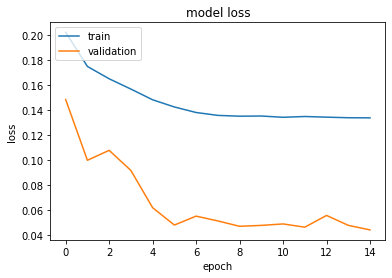

In [ ]:
# Gera gráfico para funções de perda 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

saveGraph('loss_graph', 'Train/Validation loss over epochs')

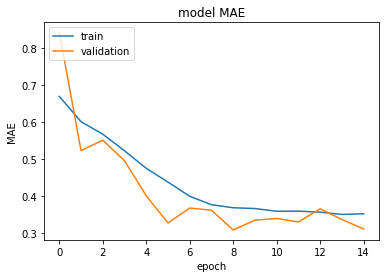

In [ ]:
# Cria gráficos para as outras métricas criadas
for metric in history.history.keys():
  if metric != 'loss' and metric.split('_')[0] != 'val':
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('model ' + metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    saveGraph(metric + '_graph', 'Train/Validation' + metric + ' over epochs')

In [ ]:
#Verifica loss e outras metricas no conjunto de teste
test_results = model.evaluate(test_input, test_output)

saveText("Complete evaluate: " + str(test_results))

4/4 [==============================] - 47s 16s/step - loss: 0.0407 - MAE: 0.3094


In [ ]:
#Verifica loss e outras metricas dos caracteres romanos e numerais no conjunto de teste
test_results = model.evaluate(test_input[:nonForeignLen], test_output[:nonForeignLen])

saveText("Non Foreign Characters Evaluate: " + str(test_results))

2/2 [==============================] - 1s 284ms/step - loss: 0.0363 - MAE: 0.3054


In [ ]:
#Verifica loss e outras metricas dos caracteres romanos e numerais no conjunto de teste
test_results = model.evaluate(test_input[nonForeignLen:], test_output[nonForeignLen:])

saveText("Foreign Characters Evaluate: " + str(test_results))

2/2 [==============================] - 49s 49s/step - loss: 0.0451 - MAE: 0.3133


In [ ]:
#Gera resultados para o conjunto de teste
results = model.predict(test_input)
print(results)

[[[[0.7789242 ]
   [0.78049535]
   [0.7908663 ]
   ...
   [0.7791543 ]
   [0.776845  ]
   [0.71355027]]

  [[0.7497221 ]
   [0.7588321 ]
   [0.78464574]
   ...
   [0.7685953 ]
   [0.77421457]
   [0.7749331 ]]

  [[0.8040215 ]
   [0.72675544]
   [0.85307604]
   ...
   [0.770075  ]
   [0.8640826 ]
   [0.7714035 ]]

  ...

  [[0.7952816 ]
   [0.7473574 ]
   [0.8037452 ]
   ...
   [0.8234737 ]
   [0.8446228 ]
   [0.79031867]]

  [[0.7748411 ]
   [0.71125734]
   [0.759492  ]
   ...
   [0.78002864]
   [0.8220377 ]
   [0.70923847]]

  [[0.76538956]
   [0.7593752 ]
   [0.788764  ]
   ...
   [0.80881727]
   [0.843494  ]
   [0.75972867]]]


 [[[0.7771962 ]
   [0.7792027 ]
   [0.7849788 ]
   ...
   [0.77826774]
   [0.775749  ]
   [0.71291226]]

  [[0.7467714 ]
   [0.75730413]
   [0.77885276]
   ...
   [0.76585263]
   [0.7715675 ]
   [0.7735733 ]]

  [[0.7994964 ]
   [0.7259989 ]
   [0.8441358 ]
   ...
   [0.76771265]
   [0.8608457 ]
   [0.77024233]]

  ...

  [[0.7932695 ]
   [0.7453688 ]
   [0.8

In [ ]:
#Gera imagem com entrada, e outra com resultado esperado e resultado para conjunto de teste
result_img = results[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(results)):
  result_img = np.hstack((result_img, results[index].reshape(OUTPUT_SHAPE))) 
  
expected_img = test_output[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(test_output)):
  expected_img = np.hstack((expected_img, test_output[index].reshape(OUTPUT_SHAPE)))
  
comparation_img = np.vstack((expected_img, result_img))

saveImage(comparation_img, "test_results_complete", "Test results complete(expected/output)")  
  
tested_img = test_input[0].reshape(INPUT_SHAPE)

for index in range(1, len(test_output)):
  tested_img = np.hstack((tested_img, test_input[index].reshape(INPUT_SHAPE)))
  
saveImage(np.array(tested_img, np.float64), "test_inputs_complete", "Test inputs complete")

In [ ]:
#Gera o mesmo que a função anterior, mas com menos exemplos para facilitar a visualização
result_img = results[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(results), NUM_FOREIGN_TEST//14):
  result_img = np.hstack((result_img, results[index].reshape(OUTPUT_SHAPE))) 
  
expected_img = test_output[0].reshape(OUTPUT_SHAPE)

for index in range(1, len(test_output), NUM_FOREIGN_TEST//14):
  expected_img = np.hstack((expected_img, test_output[index].reshape(OUTPUT_SHAPE)))
  
comparation_img = np.vstack((expected_img, result_img))

saveImage(comparation_img, "test_results", "Test results (expected/output)")  
  
tested_img = test_input[0].reshape(INPUT_SHAPE)

for index in range(1, len(test_output), NUM_FOREIGN_TEST//14):
  tested_img = np.hstack((tested_img, test_input[index].reshape(INPUT_SHAPE)))
  
saveImage(np.array(tested_img, np.float64), "test_inputs", "Test inputs")

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


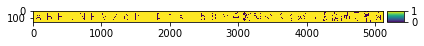

In [ ]:
#mostra entrada
ski.io.imshow(tested_img)

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


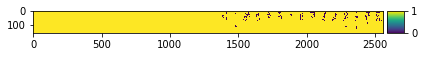

In [ ]:
#mostra resultado
comparation_img_bin = np.where(comparation_img > 0.20, 1, 0)
ski.io.imshow(comparation_img_bin)

Usar para visualizar caractere especifico

In [ ]:
def show_results(input_test, output_test, actual_output):
  input_test = input_test.reshape(INPUT_SHAPE)
  output_test = output_test.reshape(OUTPUT_SHAPE)
  actual_output = actual_output.reshape(OUTPUT_SHAPE)
  return ski.io.imshow_collection([input_test, output_test, actual_output],)

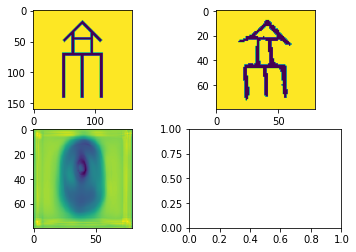

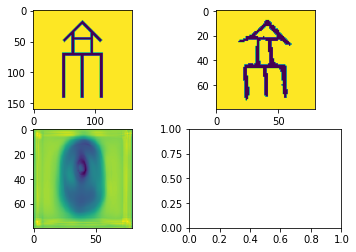

In [ ]:
example_index = 104
show_results(test_input[example_index], test_output[example_index], results[example_index])

In [ ]:
model.predict(test_input[1])

ValueError: ignored